# Bayesian Network Approach

In [45]:
from __future__ import print_function
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
from torchvision import transforms
from torch.nn import Parameter
torch.cuda.empty_cache()
import os
import numpy as np
import pandas as pd
from PIL import Image
import math
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

In [46]:
def logmeanexp(x, dim=None, keepdim=False):
    """Stable computation of log(mean(exp(x))"""

    if dim is None:
        x, dim = x.view(-1), 0
    x_max, _ = torch.max(x, dim, keepdim=True)
    x = x_max + torch.log(torch.mean(torch.exp(x - x_max), dim, keepdim=True))
    return x if keepdim else x.squeeze(dim)

# Wrapper for nn.Module with support for arbitrary flags and a universal forward pass

In [47]:
class ModuleWrapper(nn.Module):

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()

        return x, kl

# Layer - Flatten 

In [48]:
class FlattenLayer(ModuleWrapper):

    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)

# Layers - The Local Reparameterization Trick

### Convolutional Layer

In [49]:
class BBBConv2d(ModuleWrapper):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, bias=True, priors=None):
        super(BBBConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
            
        #initial mu and sigma
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        #creating distributions over weight matrix
        self.W_mu = Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        self.W_rho = Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        if self.use_bias:
            self.bias_mu = Parameter(torch.Tensor(out_channels))
            self.bias_rho = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, x, sample= True):
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias_var = self.bias_sigma ** 2
        else:
            self.bias_sigma = bias_var = None

        #Adding two more convolutional operations to calculating actual mean and actual variance
        act_mu = F.conv2d(
            x, self.W_mu, self.bias_mu, self.stride, self.padding, self.dilation, self.groups)
        act_var = 1e-16 + F.conv2d(
            x ** 2, self.W_sigma ** 2, bias_var, self.stride, self.padding, self.dilation, self.groups)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            eps = torch.empty(act_mu.size()).normal_(0, 1).to(self.device)
            return act_mu + act_std * eps
        else:
            return act_mu

    # calculating KL divergence
    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

### Fully connected Layer

In [50]:
class BBBLinear(ModuleWrapper):

    def __init__(self, in_features, out_features, bias=True, priors=None):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
                priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.Tensor(out_features, in_features))
        self.W_rho = Parameter(torch.Tensor(out_features, in_features))
        if self.use_bias:
            self.bias_mu = Parameter(torch.Tensor(out_features))
            self.bias_rho = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, x, sample=True):

        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias_var = self.bias_sigma ** 2
        else:
            self.bias_sigma = bias_var = None
        
        #Adding two more convolutional operations to calculating actual mean and actual variance
        act_mu = F.linear(x, self.W_mu, self.bias_mu)
        act_var = 1e-16 + F.linear(x ** 2, self.W_sigma ** 2, bias_var)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            eps = torch.empty(act_mu.size()).normal_(0, 1).to(self.device)
            return act_mu + act_std * eps
        else:
            return act_mu

    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

# Model- The architecture of LeNet with Bayesian Layers

In [51]:
class BBBLeNet(ModuleWrapper):

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")    

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act() #softplus or relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act() #softplus or relu
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act() #softplus or relu

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act() #softplus or relu

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

# Evaluation Metrices

In [52]:
class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean') * self.train_size + beta * kl

def acc(outputs, targets):
    return np.mean(outputs.cpu().numpy().argmax(axis=1) == targets.data.cpu().numpy())


def calculate_kl(mu_p, sig_p, mu_q, sig_q):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl


def get_beta(batch_idx, m, beta_type, epoch, num_epochs):
    if type(beta_type) is float:
        return beta_type

    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Soenderby":
        if epoch is None or num_epochs is None:
            raise ValueError('Soenderby method requires both epoch and num_epochs to be passed.')
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = 0
    return beta

# Main code block

### Methods for Preprocess dataset

In [53]:
normalize = transforms.Normalize(mean=[0.45271412],
                                     std=[0.33165374])
train_transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.RandomResizedCrop((32),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    normalize
])

### Load datasets

In [54]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample
    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='Images-processed',
                              txt_COVID='Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='Images-processed',
                              txt_COVID='Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='Images-processed',
                              txt_COVID='Data-split/COVID/testCT_COVID.txt',
                              txt_NonCOVID='Data-split/NonCOVID/testCT_NonCOVID.txt',
                              transform= val_transformer)
    print("trian_set_length=>",trainset.__len__())
    print("valid_set_length=>",valset.__len__())
    print("test_set_length=>",testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

trian_set_length=> 425
valid_set_length=> 118
test_set_length=> 203


In [55]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [56]:
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
    }
inputs = 1
outputs = 2 # two calsses

### Get Model

In [57]:
def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should [lenet]')

### Train model

In [58]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    #net = BBBLenet
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    for i, batch_samples in enumerate(trainloader, 1):
        inputs , labels = batch_samples['img'] , batch_samples['label']
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
          
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = logmeanexp(outputs, dim=2)

        beta = get_beta(i-1, len(trainloader), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list)

### Validate model

In [59]:
def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []
    
    for i , batch_samples in enumerate(validloader):
        inputs , labels = batch_samples['img'] , batch_samples['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        beta = get_beta(i-1, len(validloader), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

### Run

In [60]:
train_loss_lst = []
val_loss_lst = []
train_acc_lst = []
val_acc_lst = []
train_kl_lst= []
def runc(train_loader, valid_loader,test_loader,net_type,trainset):
    
    layer_type = 'lrt'
    activation_type = 'softplus'
    
    #prior distribution parameters
    priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
    }

    #hyperparameters
    n_epochs = 100
    lr_start = 0.001  #initial learning rate
    num_workers = 4
    valid_size = 0.2
    batch_size = 4
    train_ens = 1
    valid_ens = 1
    beta_type = 0.1  # 'Blundell', 'Standard', etc. Use float for const value
    inputs = 1
    outputs = 2

    net = getModel(net_type, inputs, outputs, priors, layer_type, activation_type).to(device)
    

    ckpt_dir = f'checkpoints'
    ckpt_name = f'checkpoints/model_{net_type}_{layer_type}_{activation_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = ELBO(len(trainset)).to(device)  #ELBO : evidence lower bound or Variational lowebound
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_max = np.Inf
    for epoch in range(n_epochs):
        train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        lr_sched.step(valid_loss)
        
        train_loss_lst.append(train_loss)
        val_loss_lst.append(valid_loss)
        train_acc_lst.append(train_acc)
        val_acc_lst.append(valid_acc)
        train_kl_lst.append(train_kl)
        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss


In [68]:
runc(train_loader, val_loader,test_loader,'lenet',trainset)

Epoch: 0 	Training Loss: 15345.3925 	Training Accuracy: 0.5327 	Validation Loss: 14198.0967 	Validation Accuracy: 0.5000 	train_kl_div: 150427.6555
Validation loss decreased (inf --> 14198.096712).  Saving model ...
Epoch: 1 	Training Loss: 13498.7943 	Training Accuracy: 0.5280 	Validation Loss: 12896.0534 	Validation Accuracy: 0.5417 	train_kl_div: 131962.5396
Validation loss decreased (14198.096712 --> 12896.053418).  Saving model ...
Epoch: 2 	Training Loss: 12448.9391 	Training Accuracy: 0.5164 	Validation Loss: 12040.2351 	Validation Accuracy: 0.5083 	train_kl_div: 121534.3645
Validation loss decreased (12896.053418 --> 12040.235124).  Saving model ...
Epoch: 3 	Training Loss: 11646.6733 	Training Accuracy: 0.5794 	Validation Loss: 11301.6964 	Validation Accuracy: 0.4583 	train_kl_div: 113624.3601
Validation loss decreased (12040.235124 --> 11301.696354).  Saving model ...
Epoch: 4 	Training Loss: 10947.9832 	Training Accuracy: 0.5304 	Validation Loss: 10632.0685 	Validation Accur

Epoch: 39 	Training Loss: 319.4312 	Training Accuracy: 0.5748 	Validation Loss: 351.0029 	Validation Accuracy: 0.4583 	train_kl_div: 299.4438
Epoch: 40 	Training Loss: 322.8079 	Training Accuracy: 0.5537 	Validation Loss: 332.9292 	Validation Accuracy: 0.5583 	train_kl_div: 287.6276
Validation loss decreased (335.248440 --> 332.929205).  Saving model ...
Epoch: 41 	Training Loss: 327.6411 	Training Accuracy: 0.5514 	Validation Loss: 326.5349 	Validation Accuracy: 0.5167 	train_kl_div: 297.5364
Validation loss decreased (332.929205 --> 326.534901).  Saving model ...
Epoch: 42 	Training Loss: 327.5964 	Training Accuracy: 0.5023 	Validation Loss: 339.3251 	Validation Accuracy: 0.5000 	train_kl_div: 279.7583
Epoch: 43 	Training Loss: 321.8038 	Training Accuracy: 0.5327 	Validation Loss: 337.9241 	Validation Accuracy: 0.4917 	train_kl_div: 270.6319
Epoch: 44 	Training Loss: 327.8172 	Training Accuracy: 0.5514 	Validation Loss: 330.0533 	Validation Accuracy: 0.5083 	train_kl_div: 283.7993
Ep

Epoch: 91 	Training Loss: 315.4297 	Training Accuracy: 0.5514 	Validation Loss: 309.1467 	Validation Accuracy: 0.6083 	train_kl_div: 221.3911
Validation loss decreased (319.141265 --> 309.146666).  Saving model ...
Epoch: 92 	Training Loss: 313.2421 	Training Accuracy: 0.5350 	Validation Loss: 330.8279 	Validation Accuracy: 0.4917 	train_kl_div: 221.3907
Epoch: 93 	Training Loss: 319.2501 	Training Accuracy: 0.5187 	Validation Loss: 324.2057 	Validation Accuracy: 0.4833 	train_kl_div: 221.3907
Epoch: 94 	Training Loss: 315.8321 	Training Accuracy: 0.5537 	Validation Loss: 339.5403 	Validation Accuracy: 0.4583 	train_kl_div: 221.3909
Epoch: 95 	Training Loss: 311.1741 	Training Accuracy: 0.5584 	Validation Loss: 329.3617 	Validation Accuracy: 0.4750 	train_kl_div: 221.3902
Epoch: 96 	Training Loss: 322.0825 	Training Accuracy: 0.5164 	Validation Loss: 312.1948 	Validation Accuracy: 0.6250 	train_kl_div: 221.3899
Epoch: 97 	Training Loss: 317.7327 	Training Accuracy: 0.5304 	Validation L

### Plot the Loss Curves

Text(0.5, 1.0, 'Loss Curves')

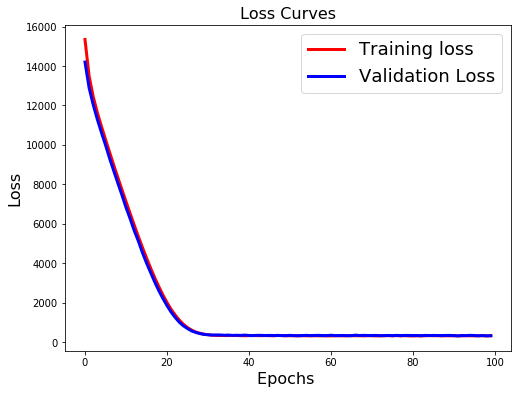

In [69]:
plt.figure(figsize=[8,6])
plt.plot(train_loss_lst,'r',linewidth=3.0)
plt.plot(val_loss_lst,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Plot the Accuracy Curves

Text(0.5, 1.0, 'Accuracy Curves')

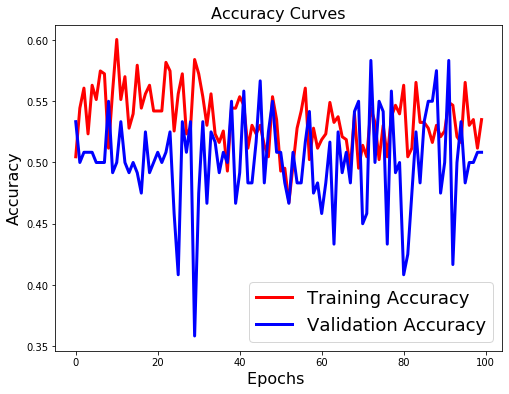

In [19]:
plt.figure(figsize=[8,6])
plt.plot(train_acc_lst,'r',linewidth=3.0)
plt.plot(val_acc_lst,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### KL Divergence

Text(0.5, 1.0, 'KL - Divergence curves')

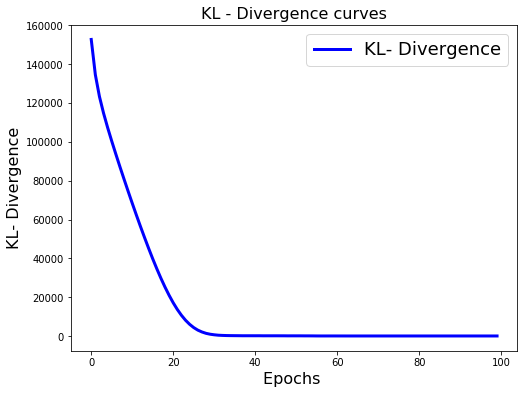

In [20]:
plt.figure(figsize=[8,6])
plt.plot(train_kl_lst,'b',linewidth=3.0)
plt.legend(['KL- Divergence'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('KL- Divergence',fontsize=16)
plt.title('KL - Divergence curves',fontsize=16)

### prediction

In [67]:
labels = ['COVID', 'NON_COVID']
model_Bayesian = BBBLeNet(outputs,inputs,priors)
checkpoint = torch.load("./checkpoints/model_lenet_lrt_softplus.pt")
model_Bayesian.load_state_dict(checkpoint)
model_Bayesian.eval()
if torch.cuda.is_available():
    model_Bayesian.cuda()
img = Image.open("./Images-processed/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png")
img_t = train_transformer(img)
batch_t = torch.unsqueeze(img_t,0).to(device)
out = model_Bayesian(batch_t)
_, index = torch.max(out[0], 1)
percentage = torch.nn.functional.softmax(out[0], dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item() ,"%")

COVID 54.05341339111328 %


### Evaluate the model

In [22]:
pred_bayesian = []
labels = ['COVID', 'NON_COVID']
for i, batch_samples in enumerate(test_loader, 1):
        inputs = batch_samples['img']
        out = model_Bayesian(inputs.to(device))
        _, index = torch.max(out[0], 1)
        pred_bayesian.append(labels[index[0]])
        
for i in range(len(pred_bayesian)):
        if pred_bayesian[i] == "COVID":
            pred_bayesian[i] = 0
        else:
            pred_bayesian[i] = 1

In [23]:
actual_lablels = []
new_actual_labels=[]
for i, batch_samples in enumerate(test_loader, 1):
        inputs , labels = batch_samples['img'] , batch_samples['label']
        actual_lablels.append(labels)
for i in range (len(actual_lablels)):
    if actual_lablels[i][0] == 1:
        new_actual_labels.append(1)
    else:
        new_actual_labels.append(0)

### Accuracy

In [24]:
accuracy_score(new_actual_labels, pred_bayesian)

0.5490196078431373

###  F1 Score

In [25]:
f1_score(new_actual_labels, pred_bayesian)

0.6101694915254238

### Confusion matirx

In [26]:
confusion_matrix(new_actual_labels, pred_bayesian)

array([[10, 15],
       [ 8, 18]], dtype=int64)

# Neural Networks approach

In [27]:
inputs = 1
outputs = 2

### Model - Lenet

In [28]:
#import torch.nn as nn
#import torch.nn.functional as F
#import numpy as np

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant(m.bias, 0)

class LeNet(nn.Module):
    def __init__(self, num_classes, inputs=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(inputs, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

## Main code block

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Get Model

In [30]:
def getModelNN(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet')

### Train Model

In [31]:
def train_model(net, optimizer, criterion, train_loader):
    train_loss = 0.0
    net.train()
    accs = []
    for i, batch_samples in enumerate(train_loader, 1):
        inputs , labels = batch_samples['img'] , batch_samples['label']
        #optimizer.zero_grad()
        
    #for data, target in train_loader:
        #data, target = data.to(device), target.to(device)
        data, target = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target) #cross entropy loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        accs.append(acc(output.detach(), target))
    return train_loss, np.mean(accs)


### Validate Model

In [32]:
def validate_model(net, criterion, valid_loader):
    valid_loss = 0.0
    net.eval()
    accs = []
    for i, batch_samples in enumerate(valid_loader, 1):
        inputs , labels = batch_samples['img'] , batch_samples['label']
        data, target = inputs.to(device), labels.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(acc(output.detach(), target))
    return valid_loss, np.mean(accs)

### Run

In [33]:
train_loss_lst = []
val_loss_lst = []
train_acc_lst = []
val_acc_lst = []

def runNN(train_loader, valid_loader,test_loader,net_type,trainset):

    # Hyper Parameter settings
    n_epochs = 100
    lr = 0.001
    num_workers = 4
    valid_size = 0.2
    batch_size = 4

    net = getModelNN(net_type, inputs, outputs).to(device)

    ckpt_dir = f'checkpoints'
    ckpt_name = f'checkpoints/model_{net_type}_neural_network.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = nn.CrossEntropyLoss() #use to calculate loss
    optimizer = Adam(net.parameters(), lr=lr)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):

        train_loss, train_acc = train_model(net, optimizer, criterion, train_loader)
        valid_loss, valid_acc = validate_model(net, criterion, valid_loader)
        lr_sched.step(valid_loss)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        train_loss_lst.append(train_loss)
        val_loss_lst.append(valid_loss)
        train_acc_lst.append(train_acc)
        val_acc_lst.append(valid_acc) 
        
        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_min = valid_loss


In [34]:
runNN(train_loader, val_loader,test_loader,'lenet',trainset)

Epoch: 1 	Training Loss: 0.6749 	Training Accuracy: 0.5771 	Validation Loss: 0.7685 	Validation Accuracy: 0.4750
Validation loss decreased (inf --> 0.768467).  Saving model ...
Epoch: 2 	Training Loss: 0.6758 	Training Accuracy: 0.5701 	Validation Loss: 0.7231 	Validation Accuracy: 0.5000
Validation loss decreased (0.768467 --> 0.723101).  Saving model ...
Epoch: 3 	Training Loss: 0.6703 	Training Accuracy: 0.5818 	Validation Loss: 0.7131 	Validation Accuracy: 0.5333
Validation loss decreased (0.723101 --> 0.713119).  Saving model ...
Epoch: 4 	Training Loss: 0.6791 	Training Accuracy: 0.5631 	Validation Loss: 0.7041 	Validation Accuracy: 0.5250
Validation loss decreased (0.713119 --> 0.704070).  Saving model ...
Epoch: 5 	Training Loss: 0.6647 	Training Accuracy: 0.5911 	Validation Loss: 0.7205 	Validation Accuracy: 0.4833
Epoch: 6 	Training Loss: 0.6628 	Training Accuracy: 0.5818 	Validation Loss: 0.7237 	Validation Accuracy: 0.5000
Epoch: 7 	Training Loss: 0.6547 	Training Accuracy:

### Plot the Loss curves

Text(0.5, 1.0, 'Loss Curves')

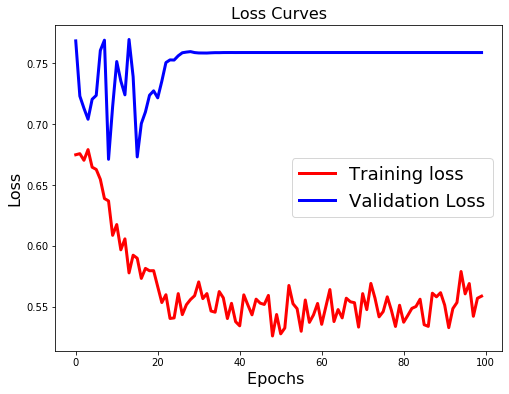

In [36]:
plt.figure(figsize=[8,6])
plt.plot(train_loss_lst,'r',linewidth=3.0)
plt.plot(val_loss_lst,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Plot the Accuracy curves

Text(0.5, 1.0, 'Accuracy Curves')

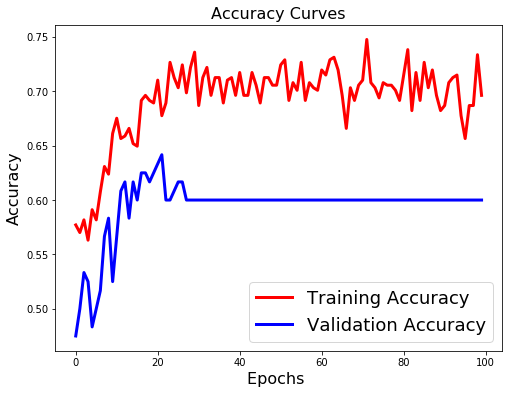

In [37]:
plt.figure(figsize=[8,6])
plt.plot(train_acc_lst,'r',linewidth=3.0)
plt.plot(val_acc_lst,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Prediction

In [38]:
labels = ['COVID', 'NON_COVID']
model_NN = LeNet(outputs,inputs)
checkpoint = torch.load("./checkpoints/model_lenet_neural_network.pt")
model_NN.load_state_dict(checkpoint)
model_NN.eval()
if torch.cuda.is_available():
    model_NN.cuda()
img = Image.open("./Images-processed/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png")
img_t = train_transformer(img)
batch_t = torch.unsqueeze(img_t,0).to(device)
out = model_NN(batch_t)
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item() ,"%")

COVID 53.19758224487305 %


### Evaluate the model

In [39]:
pred = []
labels = ['COVID', 'NON_COVID']
for i, batch_samples in enumerate(test_loader, 1):
        inputs = batch_samples['img']
        out = model_NN(inputs.to(device))
        _, index = torch.max(out, 1)
        pred.append(labels[index[0]])
        
for i in range(len(pred)):
        if pred[i] == "COVID":
            pred[i] = 0
        else:
            pred[i] = 1

### Accuracy

In [40]:
accuracy_score(new_actual_labels, pred)

0.5882352941176471

### F1 Score

In [41]:
f1_score(new_actual_labels, pred)

0.5116279069767442

### Confusion matrix

In [42]:
confusion_matrix(new_actual_labels, pred)

array([[19,  6],
       [15, 11]], dtype=int64)